In [ ]:
#@title Install required packages
!pip install deeplake hub torch torchvision scikit-learn

In [ ]:
 #@title Import used libraries
import multiprocessing
import deeplake
import torch
from torchvision.transforms import v2
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime

In [ ]:
#@title Utility functions
def seconds_to_time(seconds):
    seconds = int(seconds)
    s = seconds % 60
    m = seconds // 60
    if m == 0:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h == 0:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [ ]:
#@title Torchvision training and evaluation helper functions
def train_epoch(model, train_loader, optimizer, loss_func):
    model.train()
    train_loss_accumulator = 0.0

    for images, sizes in train_loader:
        images = images.to(device).float()
        sizes = sizes.to(device).float()

        predicted_sizes = model(images)

        loss = loss_func(predicted_sizes, sizes.unsqueeze(1))
        train_loss_accumulator += loss.item() * images.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = train_loss_accumulator / len(train_loader.dataset)
    return train_loss

def evaluate(model, loader, loss_func):
    model.eval()

    total_loss = 0.0
    total_samples = 0

    for images, sizes in loader:
        images = images.to(device)
        sizes = sizes.to(device)

        with torch.no_grad():
            predicted_sizes = model(images)

        batch_loss = loss_func(predicted_sizes, sizes.unsqueeze(1))
        total_loss += batch_loss.item() * images.size(0)
        total_samples += images.size(0)

    average_loss = total_loss / total_samples
    return average_loss

In [ ]:
#@title Define common constants
batch_size = 16
num_workers = multiprocessing.cpu_count()

In [ ]:
#@title Define transformations for training and testing of samples
class ShoeSizeTransform(torch.nn.Module):
    def __init__(self, shoe_areas, shoe_lengths):
        super().__init__()
        self.shoe_areas = shoe_areas
        self.shoe_lengths = shoe_lengths

    def forward(self, object_scale):
        shoe_length = object_scale[2] * 100
        shoe_area = shoe_length * object_scale[0] * 100
        nearest_size_length = min(self.shoe_lengths, key = lambda x: abs(x - shoe_length))
        nearest_size_area = min(self.shoe_areas, key = lambda x: abs(x - shoe_area))
        return (shoe_lengths[nearest_size_length] + shoe_areas[nearest_size_area]) / 2

class ObjectronTransforms(torch.nn.Module):
    def __init__(self, transforms, shoe_areas, shoe_lengths):
        super().__init__()
        self.transforms = transforms
        self.shoe_size_transforms = ShoeSizeTransform(shoe_areas, shoe_lengths)

    def forward(self, sample):
        image, object_scale = sample['image'], sample['object_scale']
        transformed_image = self.transforms(image)
        shoe_size = self.shoe_size_transforms(object_scale)

        return [transformed_image, shoe_size]

shoe_lengths = { 22.0: 35, 22.7: 36, 23.3: 37, 24.0: 38, 24.7: 39, 25.3: 40, 26.0: 41,
                 26.7: 42, 27.3: 43, 28.0: 44, 28.7: 45, 29.3: 46, 30.0: 47, 30.7: 48 }
shoe_areas = { 193.6: 35, 206.26: 36, 216.92: 37, 230.4: 38, 244.72: 39, 255.88: 40, 270.4: 41,
               282.28: 42, 294.92: 43, 306.6: 44, 318.32: 45, 330.72: 46, 342.0: 47, 354.84: 48 }

transforms_train = v2.Compose([
    v2.RandomRotation(20),
    v2.Resize((128, 128)),
    v2.ColorJitter(0.2, 0.2, 0.1, 0.1),
    v2.RandomAdjustSharpness(random.uniform(0.5, 1.5)),
    v2.RandomEqualize(),
    v2.RandomPosterize(2),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])
transforms_test = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

transforms_train = ObjectronTransforms(transforms_train, shoe_areas, shoe_lengths)
transforms_test = ObjectronTransforms(transforms_test, shoe_areas, shoe_lengths)

In [ ]:
#@title Initialize datasets
shoe_train = deeplake.load("hub://activeloop/objectron_shoe_train").filter(lambda sample: sample['instance_num'].numpy()[0] == 1 and sample['image_id'].numpy()[0] % 100 == 0, num_workers = num_workers)
shoe_test = deeplake.load("hub://activeloop/objectron_shoe_test").filter(lambda sample: sample['instance_num'].numpy()[0] == 1 and sample['image_id'].numpy()[0] % 100 == 0, num_workers = num_workers)

train_loader = shoe_train.pytorch(num_workers = num_workers, batch_size = batch_size, shuffle = True, transform = transforms_train, tensors = ["image", "object_scale"])
test_loader = shoe_test.pytorch(num_workers = num_workers, batch_size = batch_size, shuffle = False, transform = transforms_test, tensors = ["image", "object_scale"])
print(f'Successfully initialized the data loaders. Total images count:\n- Train: {len(shoe_train)}\n- Test: {len(shoe_test)}')

Please wait, filling up the shuffle buffer with samples.:   0%|          | 0.00/1.91G [00:00<?, ?B/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 1.91G/1.91G [05:06<00:00, 6.68MB/s]


Shuffle buffer filling is complete.


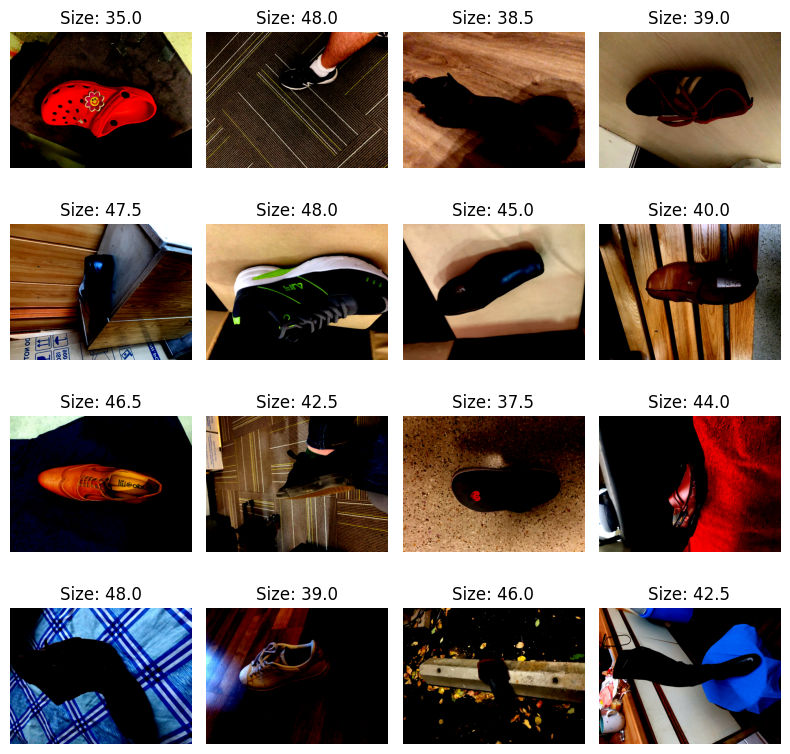

In [ ]:
#@title Display train dataset
num_cols = 4
fig, ax = plt.subplots(math.ceil(batch_size / num_cols), num_cols, figsize = (8, 8))
images, shoe_sizes = next(iter(train_loader))
for i, [image, shoe_size] in enumerate(zip(images, shoe_sizes)):

  ax[math.floor(i / num_cols)][i % num_cols].title.set_text(f'Size: {shoe_size}')
  ax[math.floor(i / num_cols)][i % num_cols].imshow(np.transpose(image, (2, 1, 0)));
  ax[math.floor(i / num_cols)][i % num_cols].axis('off')

fig.tight_layout();
plt.show()

In [ ]:
#@title Select the most powerful available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device to be used: {device}.")

The device to be used: cuda.


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 1.91G/1.91G [04:58<00:00, 6.85MB/s]


Shuffle buffer filling is complete.


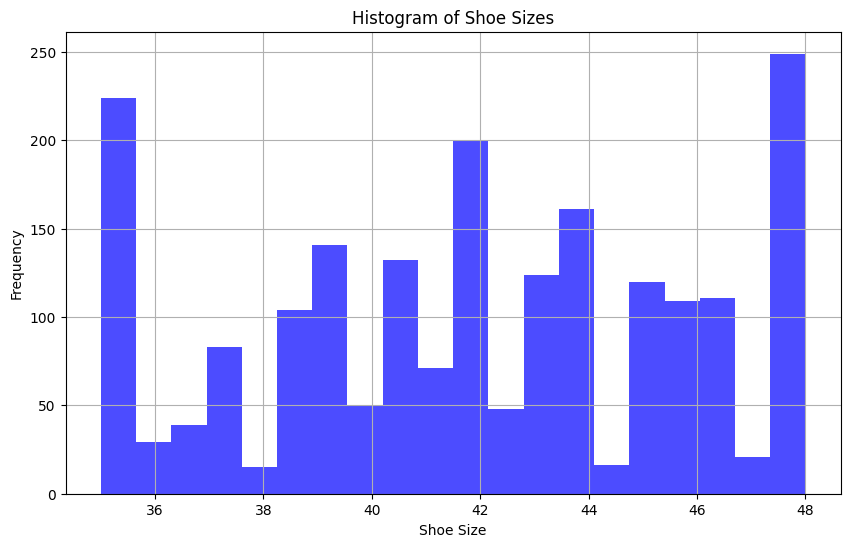

In [ ]:
all_shoe_sizes = []

# Iterate through the data loader
for batch in train_loader:
    # Extract shoe sizes from the batch
    _, shoe_sizes = batch
    # Append shoe sizes to the list
    all_shoe_sizes.extend(shoe_sizes.numpy())

# Convert the list to numpy array for plotting
all_shoe_sizes = np.array(all_shoe_sizes)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_shoe_sizes, bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Shoe Sizes')
plt.xlabel('Shoe Size')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
#@title Model implementation
class ShoeSizePredictor(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)

        # Third convolutional block
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.bn6 = nn.BatchNorm2d(256)

        # Fourth convolutional block
        self.conv7 = nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.bn8 = nn.BatchNorm2d(512)

        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        # Third convolutional block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        # Fourth convolutional block
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.max_pool2d(x, kernel_size = 2, stride = 2)

        # Global average pooling
        x = self.avgpool(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Dropout and fully connected layer
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [ ]:
#@title Initialize custom model architecture
model = ShoeSizePredictor().to(device)
model.load_state_dict(torch.load('./model_weights.pth', map_location = device))
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Parameter count: 4,689,729


In [ ]:
#@title Train and evaluate model's accuracy after each epoch
epoch_count = 100
lr = 1e-3
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5)
start_time = datetime.now()

best_loss = float('inf')

for epoch in range(epoch_count):
    train_loss = train_epoch(model, train_loader, optimizer, loss_func)
    test_loss = evaluate(model, test_loader, loss_func)

    scheduler.step(train_loss)
    torch.save(model.state_dict(), f'model_weights_{epoch + 1}.pth')

    print(f'Epoch: {epoch + 1}, Time: {seconds_to_time((datetime.now() - start_time).total_seconds())}')
    print(f'   Train loss: {train_loss}')
    print(f'   Test loss:  {test_loss}')

    if test_loss < best_loss:
        best_loss = test_loss
        print(f'    Epoch: {epoch + 1} had new best loss: {best_loss}')

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ShoeSizePredictorResNet(nn.Module):
    def __init__(self):
        super(ShoeSizePredictorResNet, self).__init__()

        self.layer1 = self._make_layer(3, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1)
        self.dropout = nn.Dropout(p=0.5)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

model2 = ShoeSizePredictorResNet().to(device)
print(f'Parameter count: {sum(p.numel() for p in model2.parameters() if p.requires_grad):,}')

Parameter count: 11,137,473


In [ ]:
model2.load_state_dict(torch.load('./model_weights.pth', map_location = device))

<All keys matched successfully>

In [ ]:
#@title Train and evaluate model's accuracy after each epoch
epoch_count = 50
lr = 1e-3
loss_func = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 5)
start_time = datetime.now()

best_loss = float('inf')

for epoch in range(epoch_count):
    train_loss = train_epoch(model2, train_loader, optimizer, loss_func)
    test_loss = evaluate(model2, test_loader, loss_func)

    scheduler.step(train_loss)
    torch.save(model2.state_dict(), f'model_weights_{epoch + 1}.pth')

    print(f'Epoch: {epoch + 1}, Time: {seconds_to_time((datetime.now() - start_time).total_seconds())}')
    print(f'   Train loss: {train_loss}')
    print(f'   Test loss:  {test_loss}')

    if test_loss < best_loss:
        best_loss = test_loss
        print(f'    Epoch: {epoch + 1} had new best loss: {best_loss}')

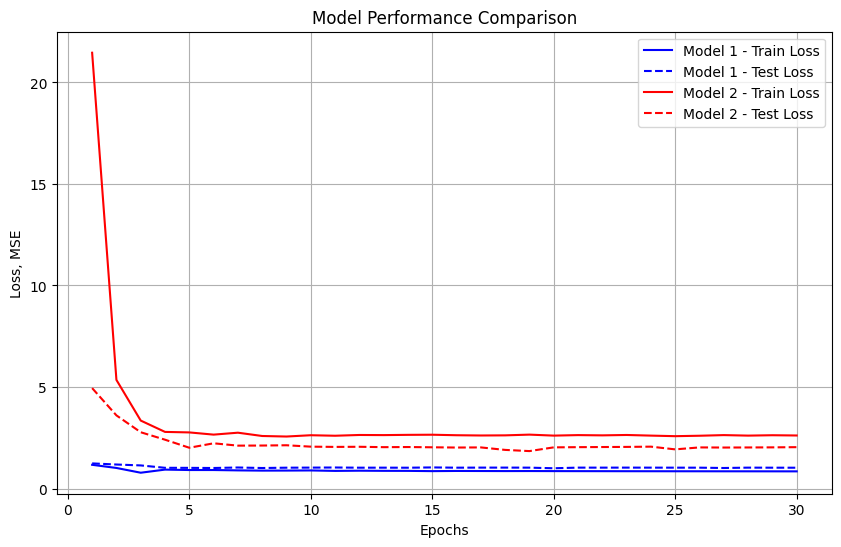

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_model1, label='Model 1 - Train Loss', color='blue')
plt.plot(epochs, test_loss_model1, label='Model 1 - Test Loss', linestyle='--', color='blue')
plt.plot(epochs, train_loss_model2, label='Model 2 - Train Loss', color='red')
plt.plot(epochs, test_loss_model2, label='Model 2 - Test Loss', linestyle='--', color='red')
plt.title('Model Performance Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss, MSE')
plt.legend()
plt.grid(True)
plt.show()